<a href="https://colab.research.google.com/github/RedShoreTech/OASIS-baselines/blob/main/OASIS_Alzheimer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# 首先导入必要的库
import os
import requests
import tarfile
from google.colab import drive
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
import seaborn as sns# 用于读取NIfTI文件
import nibabel as nib  # 用于读取NIfTI文件
from sklearn.model_selection import train_test_split
import random

# 安装nvidia-smi的Python包装器
!pip install gputil
import GPUtil

!pip install torchinfo
from torchsummary import summary
from torchinfo import summary

from torch.amp import autocast
from torch.amp import GradScaler
from torch.cuda import amp

In [17]:

DRIVE_ROOT_PATH = '/content/drive'
# 挂载Google Drive
# 检查是否已经挂载
if not os.path.exists(DRIVE_ROOT_PATH):
    # 挂载Google Drive
    drive.mount(DRIVE_ROOT_PATH)
else:
    print("Google Drive已经挂载。")

# 如果需要卸载并重新挂载
# !fusermount -u /content/drive
# drive.mount('/content/drive')

# 定义目标文件夹
DATASET_PATH = os.path.join(DRIVE_ROOT_PATH, 'MyDrive/datasets/oas2')

# 定义下载链接
DOWNLOAD_URLS = [
    'https://download.nrg.wustl.edu/data/OAS2_RAW_PART1.tar.gz',
    'https://download.nrg.wustl.edu/data/OAS2_RAW_PART2.tar.gz'
]

def create_directory(path):
    """创建目录如果不存在"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"创建目录: {path}")
    else:
        print(f"目录已存在: {path}")

def download_file(url, dest_path):
    """下载文件并显示进度条"""
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    # 获取文件名
    filename = url.split('/')[-1]
    file_path = os.path.join(dest_path, filename)

    # 如果文件已存在，跳过下载
    if os.path.exists(file_path):
        print(f"文件已存在: {filename}")
        return file_path

    print(f"开始下载: {filename}")
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

    with open(file_path, 'wb') as file:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    return file_path

def extract_tar_gz(file_path, extract_path):
    """解压tar.gz文件"""
    print(f"开始解压: {os.path.basename(file_path)}")
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print(f"解压完成: {os.path.basename(file_path)}")

def check_extracted_files(extract_path):
    """检查是否已有解压的文件"""
    # 检查是否存在典型的OAS2文件夹结构
    sample_dirs = ['OAS2_RAW_PART1/', 'OAS2_RAW_PART2/']  # 示例目录名
    # print(f"Check path:{os.path.join(extract_path, sample_dirs[0])}")
    return any(os.path.exists(os.path.join(extract_path, d)) for d in sample_dirs)

# def main():


# if __name__ == "__main__":
#     main()

Google Drive已经挂载。


In [18]:
# 创建目标目录
create_directory(DATASET_PATH)

def prepareDatasets():
  # 检查是否已有解压的文件
  if check_extracted_files(DATASET_PATH):
      print("检测到已解压的文件，跳过下载和解压步骤")
      return

  # 创建临时目录用于下载
  temp_dir = '/content/temp_downloads'
  create_directory(temp_dir)

  try:
      # 下载并解压文件
      for url in DOWNLOAD_URLS:
          # 下载文件
          file_path = download_file(url, temp_dir)
          # 解压文件
          extract_tar_gz(file_path, DATASET_PATH)

  finally:
      # 清理临时文件
      if os.path.exists(temp_dir):
          shutil.rmtree(temp_dir)
          print("清理临时文件完成")

prepareDatasets()

目录已存在: /content/drive/MyDrive/datasets/oas2
检测到已解压的文件，跳过下载和解压步骤


In [19]:
# 定义本地文件路径和下载URL
EXCEL_FILENAME = 'oasis_longitudinal_demographics.xlsx'
EXCEL_FILEPATH = os.path.join(DATASET_PATH, EXCEL_FILENAME)
DOWNLOAD_URL = 'https://sites.wustl.edu/oasisbrains/files/2024/03/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx'

# 创建目录如果不存在
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

# 检查文件是否存在
if not os.path.exists(EXCEL_FILEPATH):
    print(f"文件不存在，开始下载: {EXCEL_FILENAME}")
    response = requests.get(DOWNLOAD_URL)
    with open(EXCEL_FILEPATH, 'wb') as file:
        file.write(response.content)
    print(f"下载完成并保存到: {EXCEL_FILEPATH}")
else:
    print(f"文件已存在: {EXCEL_FILEPATH}")

# 看看label文件长啥样
labels_dataframe = pd.read_excel(EXCEL_FILEPATH)
labels_dataframe.head(5)
labels_dataframe.describe()

文件已存在: /content/drive/MyDrive/datasets/oas2/oasis_longitudinal_demographics.xlsx


,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.121584,0.729556,1.195460
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.135956,0.037141,0.138105
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.330000,0.700191,1.098979
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.041312,0.728789,1.193844
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1596.936793,0.755669,1.292980
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


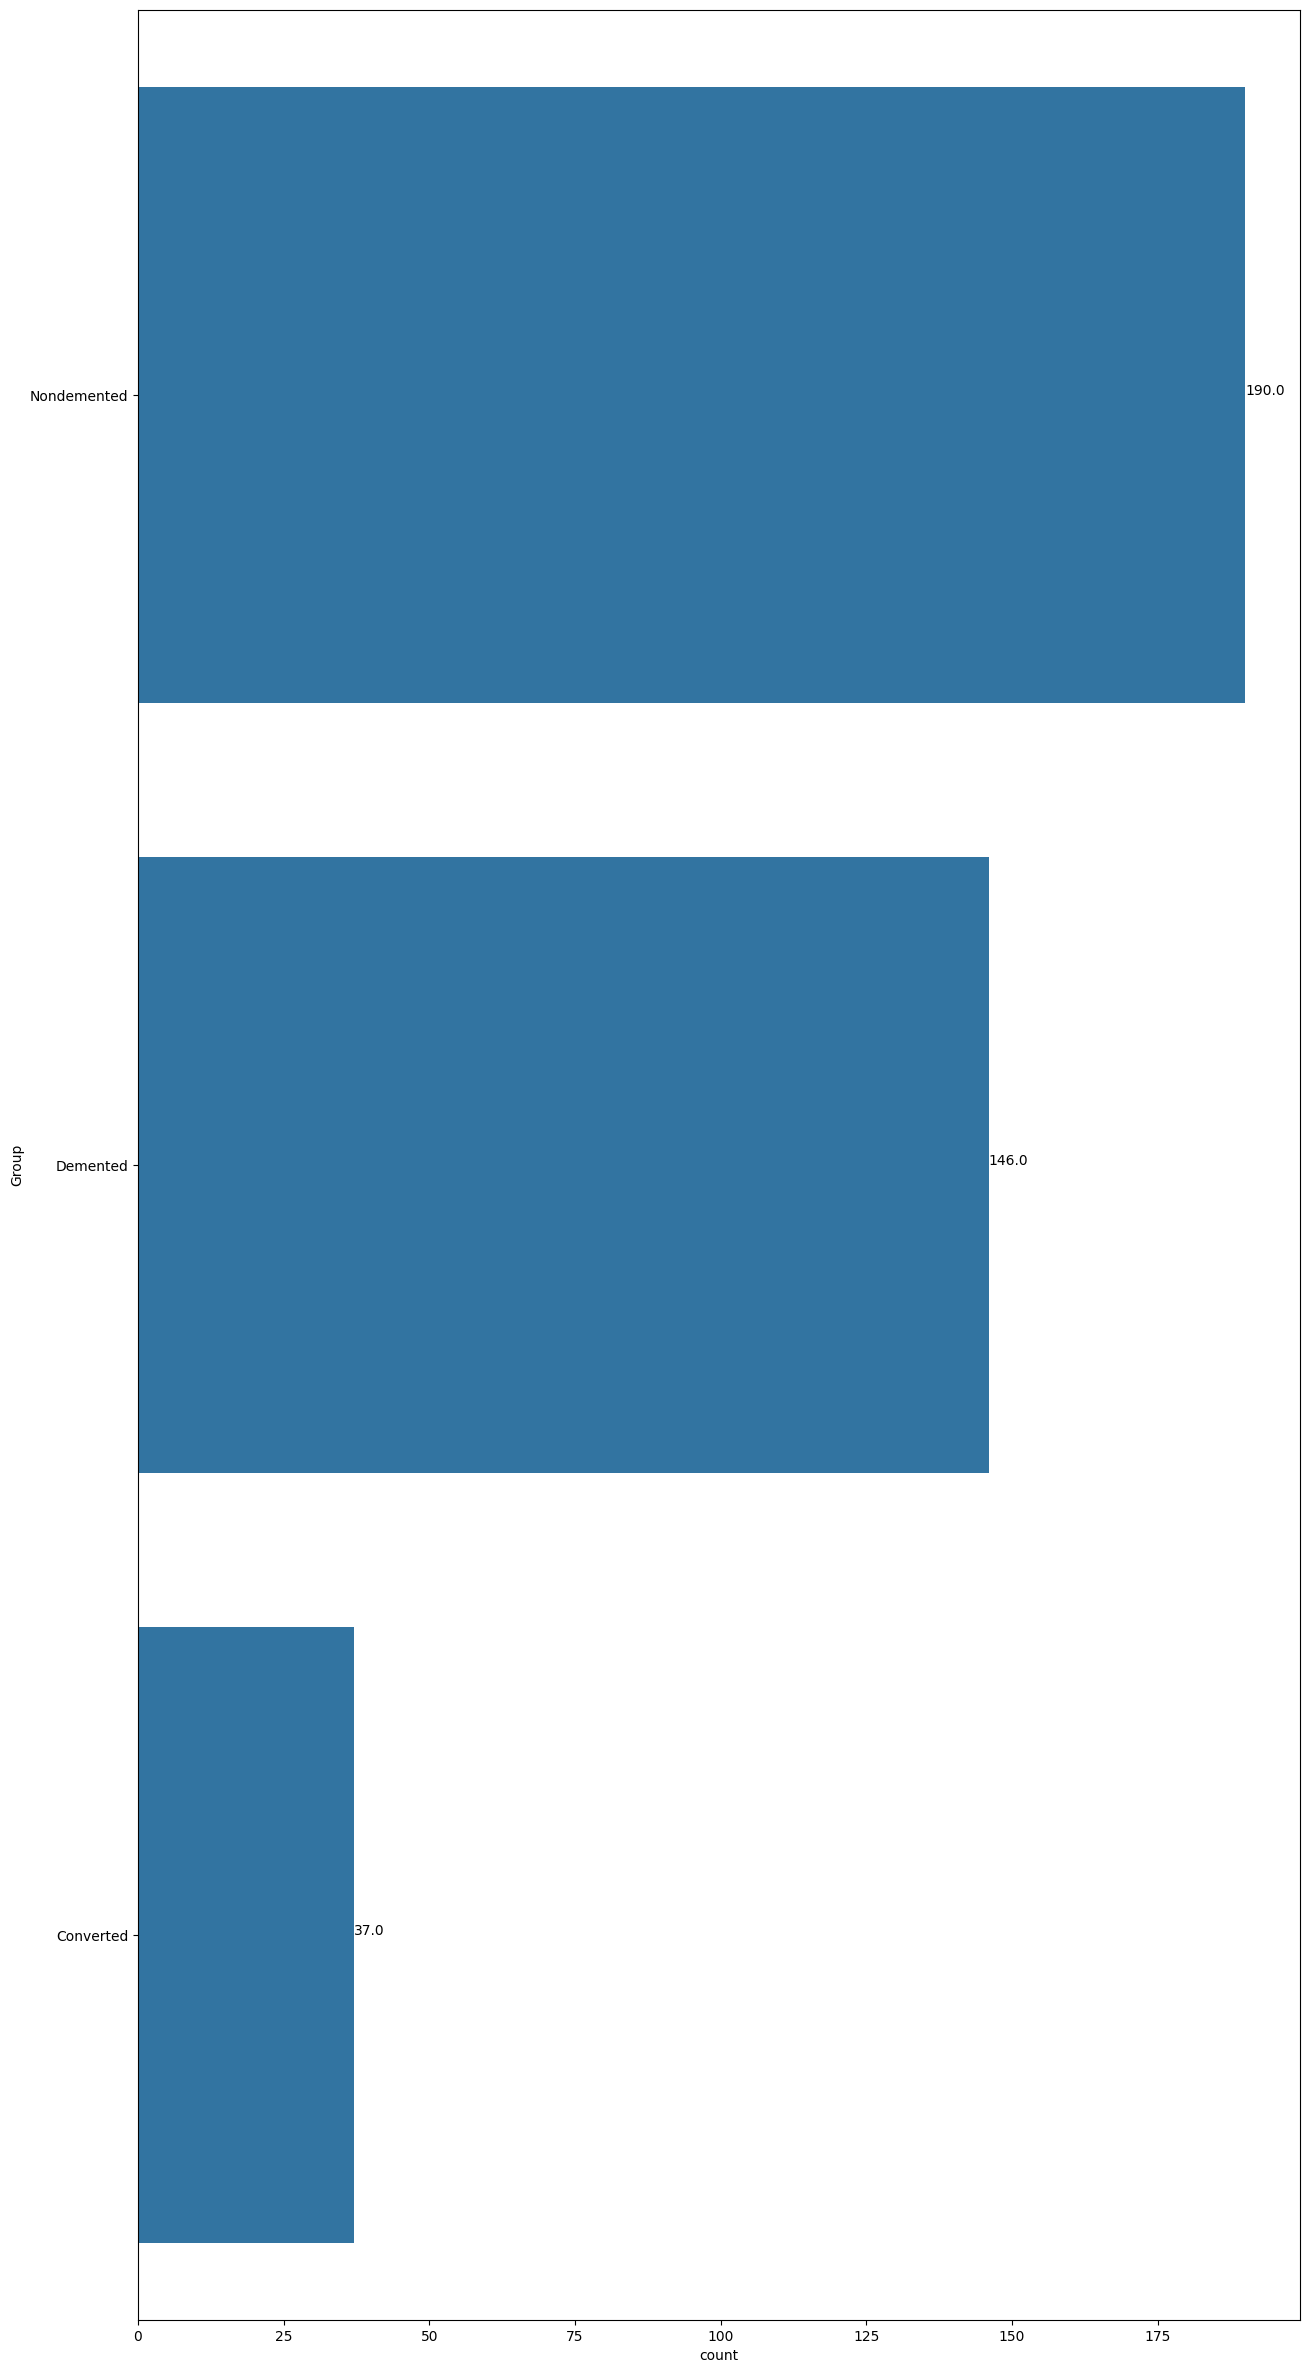

In [20]:
#function to show bar length
def barw(ax):

    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))

#finding top leaves

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['Group'],order=labels_dataframe['Group'].value_counts().index)
barw(ax0)
plt.show()

In [21]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['Group'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

3


{'Converted': 0, 'Demented': 1, 'Nondemented': 2}

In [31]:
def recursive_file_iterator(root_dir):
    """生成器函数，递归遍历目录下的所有文件"""
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # print(f"dirpath={dirpath},\ndirnames={dirnames},\nfilenames={filenames}\n")
        for filename in filenames:
            yield os.path.join(dirpath, filename)

def read_nifti_file(filepath):
    """读取和加载数据"""
    # 读取文件
    scan = nib.load(filepath)
    # 获取原始数据
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """数据归一化"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    # plt.imshow(volume[:, :, 30], cmap="gray")
    # plt.show() ##For Debug
    return volume

def resize_volume(img):
    """跨 z 轴调整大小"""
    # 设置所需的深度
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # 获取当前深度
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # 计算深度因子
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    # 旋转
    img = ndimage.rotate(img, 90, reshape=False)
    # 跨z轴调整大小
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor, 1), order=1)
    return img

def process_scan(path):
    """读取和调整数据大小"""
    # 读取扫描文件
    volume = read_nifti_file(path)
    # 归一化
    volume = normalize(volume)
    # 调整宽度、高度和深度
    volume = resize_volume(volume)
    return volume

class NIfTIData(Dataset):
    def __init__(self, metadata_path, root_dir, mode='train', transform=None, train_ratio=0.6, val_ratio=0.2):
        """
        参数:
            metadata_path (string): 元数据Excel/CSV文件路径
            root_dir (string): NIfTI文件所在的根目录
            mode (string): 'train', 'valid', 或 'test'
            transform (callable, optional): 可选的图像转换
            train_ratio (float): 训练集比例，默认0.6
            val_ratio (float): 验证集比例，默认0.2
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        # 验证比例参数
        assert 0 < train_ratio < 1, "训练集比例必须在0和1之间"
        assert 0 < val_ratio < 1, "验证集比例必须在0和1之间"
        assert train_ratio + val_ratio < 1, "训练集和验证集比例之和必须小于1"
        # 读取元数据
        if metadata_path.endswith('.xlsx'):
            print(f"XLSX file exists: {metadata_path}")
            self.metadata = pd.read_excel(metadata_path)
        else:
            print(f"CSV file exists: {metadata_path}")
            self.metadata = pd.read_csv(metadata_path)
        # 分割数据集
        all_subjects = sorted(list(set(self.metadata['Subject ID'])))
        n_subjects = len(all_subjects)
        # 添加调试打印
        print(f"Searching for NIfTI files in: {root_dir}")
        print(f"# Subjects: {n_subjects}")
        # 创建MRI ID到文件路径的映射
        self.mriID_paths_map = {}
        # 递归搜索所有子目录
        for root, _, files in os.walk(root_dir):
            path_components = os.path.normpath(root).split(os.sep)
            mri_id = path_components[-2]
            if mri_id not in self.metadata['MRI ID'].values:
                continue
            for file in files:
                if file.endswith('.img'):
                    if mri_id not in self.mriID_paths_map:
                        self.mriID_paths_map[mri_id] = []
                    self.mriID_paths_map[mri_id].append(os.path.join(root, file))

        n_mriIDs = len(self.mriID_paths_map)
        print(f"# MRI IDs: {n_mriIDs}")
        all_mriIDs = sorted(list(self.mriID_paths_map.keys()))

        # # Naive sampling:
        # train_idx = int(train_ratio * n_mriIDs)
        # val_idx = int((train_ratio + val_ratio) * n_mriIDs)
        # if mode == 'train':
        #     selected_mriIDs = all_mriIDs[:train_idx]
        # elif mode == 'valid':
        #     selected_mriIDs = all_mriIDs[train_idx:val_idx]
        # else:  # test
        #     selected_mriIDs = all_mriIDs[val_idx:]
        ###
        # Stratified sampling based on 'Group' column (labels)
        train_mriIDs, remaining_mriIDs = train_test_split(
            all_mriIDs,
            test_size = 1 - train_ratio,
            stratify=self.metadata[self.metadata['MRI ID'].isin(all_mriIDs)]['Group'],
            random_state=42  # Optional: for reproducibility
        )

        val_mriIDs, test_mriIDs = train_test_split(
            remaining_mriIDs,
            test_size = (1 - train_ratio - val_ratio) / (1 - train_ratio),
            stratify=self.metadata[self.metadata['MRI ID'].isin(remaining_mriIDs)]['Group'],
            random_state=42  # Optional: for reproducibility
        )

        if mode == 'train':
            selected_mriIDs = train_mriIDs
        elif mode == 'valid':
            selected_mriIDs = val_mriIDs
        else:  # test
            selected_mriIDs = test_mriIDs


        # 筛选对应模式的数据
        mode_metadata = self.metadata[self.metadata['MRI ID'].isin(selected_mriIDs)]
        # 构建有效的文件列表
        self.mriIDs = []
        self.labels = []
        self.paths = []
        # 遍历筛选后的元数据
        for _, row in mode_metadata.iterrows():
            mri_id = row['MRI ID']
            label = row['Group']
            if label != 'Converted':
            # if True:
                for path in self.mriID_paths_map[mri_id]:
                    self.mriIDs.append(mri_id)
                    self.labels.append(label)
                    self.paths.append(path)

        print(f"Finished reading the {mode} set of NIfTI Dataset ({len(self.mriIDs)} samples found)")
        print(f"Demented cases: {self.labels.count('Demented')}")
        print(f"Non-demented cases: {self.labels.count('Nondemented')}")

    def __len__(self):
        return len(self.mriIDs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        ## mriID = self.mriIDs[idx]
        label = self.labels[idx]
        path = self.paths[idx]
        cachedFile = f"{path}.npy"
        if os.path.exists(cachedFile):
        ## if False: ##For Debug
            imgData = np.load(cachedFile)
        else:
            imgData = process_scan(path)
            np.save(cachedFile, imgData)
        ###if self.mode == 'train':
        ###    imgData = self.rotate(imgData)
        imgData = np.array(imgData).astype(np.float32)
        ###??? imgData = np.expand_dims(imgData, 3)
        label = np.array([class_to_num[label]]).astype(np.int64)
        return imgData, label

    def rotate(self,volume):
        # 定义增强旋转角度
        angles = [-20, -10, -5, 5, 10, 20]
        # 随机选择一个角度
        angle = random.choice(angles)
        # 旋转CT
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

In [23]:
# Set the environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def monitor_gpu():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f'GPU ID: {gpu.id}')
        print(f'GPU名称: {gpu.name}')
        print(f'GPU负载: {gpu.load*100}%')
        print(f'GPU内存使用: {gpu.memoryUsed}MB / {gpu.memoryTotal}MB')
        print(f'GPU温度: {gpu.temperature} °C')

# 检查GPU内存使用情况
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"分配的GPU内存: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"缓存的GPU内存: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# 3. 定期释放未使用的内存
def cleanup():
    torch.cuda.empty_cache()
    import gc
    gc.collect()

print("CUDA是否可用:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU名称:", torch.cuda.get_device_name(0))
    print("GPU数量:", torch.cuda.device_count())
    print("当前GPU索引:", torch.cuda.current_device())

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("使用设备:", device)

# 清理GPU缓存
cleanup()

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

CUDA是否可用: True
GPU名称: NVIDIA A100-SXM4-40GB
GPU数量: 1
当前GPU索引: 0
使用设备: cuda
Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [32]:

train_path = EXCEL_FILEPATH
test_path = EXCEL_FILEPATH
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = '/content/drive/MyDrive/datasets/oas2/'

train_dataset = NIfTIData(metadata_path=train_path, root_dir=img_path, mode='train')
val_dataset = NIfTIData(metadata_path=train_path, root_dir=img_path, mode='valid')
test_dataset = NIfTIData(metadata_path=test_path, root_dir=img_path, mode='test')

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, num_workers=4, pin_memory=True)


XLSX file exists: /content/drive/MyDrive/datasets/oas2/oasis_longitudinal_demographics.xlsx
Searching for NIfTI files in: /content/drive/MyDrive/datasets/oas2/
# Subjects: 150
# MRI IDs: 373
Finished reading the train set of NIfTI Dataset (740 samples found)
Demented cases: 321
Non-demented cases: 419
XLSX file exists: /content/drive/MyDrive/datasets/oas2/oasis_longitudinal_demographics.xlsx
Searching for NIfTI files in: /content/drive/MyDrive/datasets/oas2/
# Subjects: 150
# MRI IDs: 373
Finished reading the valid set of NIfTI Dataset (237 samples found)
Demented cases: 117
Non-demented cases: 120
XLSX file exists: /content/drive/MyDrive/datasets/oas2/oasis_longitudinal_demographics.xlsx
Searching for NIfTI files in: /content/drive/MyDrive/datasets/oas2/
# Subjects: 150
# MRI IDs: 373
Finished reading the test set of NIfTI Dataset (257 samples found)
Demented cases: 104
Non-demented cases: 153


(128, 128, 64, 1)
Dimension of the MRI scan is: (128, 128, 64, 1)


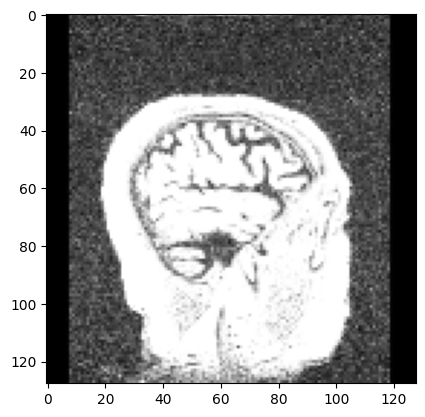

(128, 128, 64, 1)


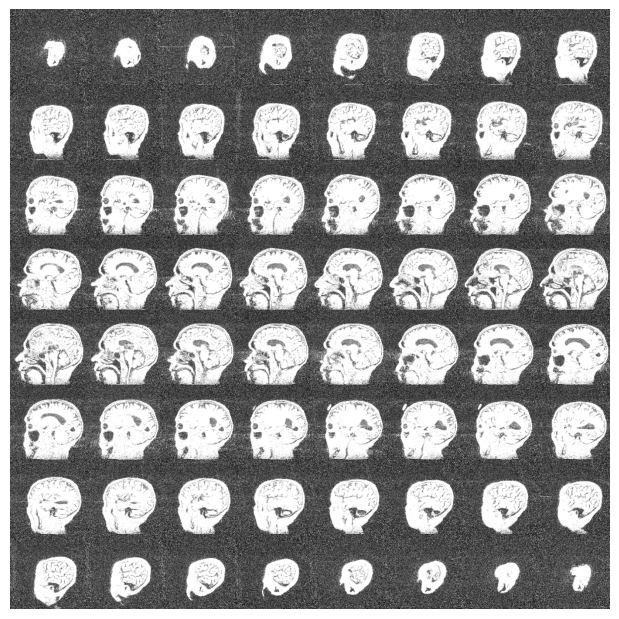

In [26]:
images, labels = train_dataset[0]
### images, labels = train_dataset.__getitem__(0)
print(images.shape)
###??? image = np.squeeze(images, 3)
image = images
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 52]), cmap="gray")
plt.show()

def plot_slices(num_rows, num_columns, width, height, data):
    """绘制CT的横断面"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 6.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

images, labels  = test_dataset[0]
image = np.squeeze(images, 3)
print(images.shape)
# 绘制CT横断面.
plot_slices(8, 8, 128, 128, image[:, :, :64])

In [27]:
# 3D CNN网络
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.layerAll = nn.Sequential(
            nn.Conv3d(in_channels=1,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.BatchNorm3d(64),

            nn.Conv3d(in_channels=64,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.BatchNorm3d(64),

            nn.Conv3d(in_channels=64,out_channels=128,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.BatchNorm3d(128),

            nn.Conv3d(in_channels=128,out_channels=256,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.BatchNorm3d(256),

            nn.AdaptiveAvgPool3d(output_size=1),
            nn.Flatten(),
            nn.Linear(256,512),
            nn.Dropout(p=0.3),

            nn.Linear(512,1),
            nn.Sigmoid()
        )

        self.feature_maps = {}
        ## 添加钩子
        def hook_fn(name):
            def hook(module, input, output):
                self.feature_maps[name] = output
            return hook
        # 在关键层注册钩子
        self.layerAll[0].register_forward_hook(hook_fn('first_conv'))  # 第一个卷积层
        self.layerAll[3].register_forward_hook(hook_fn('first_bn'))    # 第一个BN层
        self.layerAll[7].register_forward_hook(hook_fn('middle_conv')) # 中间卷积层
        self.layerAll[-4].register_forward_hook(hook_fn('final_conv')) # 最后的卷积层

    def forward(self, inputs):
        # # 检查输入数据的范围和统计信息
        # print(f"Input shape: {inputs.shape}")
        # print(f"Input range: [{inputs.min():.4f}, {inputs.max():.4f}]")
        # print(f"Input mean: {inputs.mean():.4f}, std: {inputs.std():.4f}")
        # 因为数据输入是 【批次、宽度、高度、深度、通道】，调整认输入要求，【批次、通道、深度、宽度、高度】
        inputs = inputs.permute(0,4,3,1,2)
        # print(f"After permute shape: {inputs.shape}")
        x = self.layerAll(inputs)
        # print(f"Final output: shape={x.shape}, mean={x.mean():.4f}, std={x.std():.4f}")
        return x

In [28]:
# 如何判断问题：
# 梯度消失的特征图特征：
# 后层的特征图值都接近于0
# 特征图的标准差（std）很小（比如<0.01）
# 特征图看起来模糊，没有清晰的特征边界
# 不同通道的特征图相似度高
# 特征图退化的特征：
# 特征图完全相同或高度相似
# 大片区域的值相同
# 特征图缺乏细节和纹理信息
# 后层的特征图没有提取出更高级的特征
# 3. 正常特征图的特征：
# 浅层特征图：边缘和纹理信息清晰
# 深层特征图：更抽象的特征模式
# 不同通道捕获不同类型的特征
# 特征图的值分布合理（不会过于集中）
# 建议的调试步骤：
# 首先检查第一个卷积层的输出：

# 如果发现问题，可以尝试以下解决方案：
# 调整学习率
# 添加残差连接
# 使用BatchNorm
# 改变初始化方法
# 调整网络深度
# 这样的可视化和监控可以帮助你更好地理解网络的学习过程，发现潜在的问题。

# def visualize_feature_maps(feature_maps, layer_name):
#     """可视化3D特征图的中间切片"""
#     import matplotlib.pyplot as plt

#     # 选择batch中的第一个样本，第一个通道的中间切片
#     middle_slice = feature_maps[0, 0, feature_maps.shape[2]//2].detach().cpu()

#     plt.figure(figsize=(8, 8))
#     plt.imshow(middle_slice, cmap='viridis')
#     plt.title(f'{layer_name} - Middle Slice')
#     plt.colorbar()
#     plt.show()
def visualize_feature_maps(feature_maps, layer_name):
    """增强版特征图可视化"""
    # 获取中间切片
    if len(feature_maps.shape) == 5:  # (batch, channels, depth, height, width)
        # 选择第一个样本，展示多个通道
        middle_slice_idx = feature_maps.shape[2] // 2
        feature_slice = feature_maps[0, :, middle_slice_idx].detach().cpu()
        # 计算统计信息
        mean_val = feature_slice.mean().item()
        std_val = feature_slice.std().item()
        max_val = feature_slice.max().item()
        min_val = feature_slice.min().item()
        # 选择前4个通道进行可视化
        num_channels = min(4, feature_slice.shape[0])
        fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
        for i in range(num_channels):
            if num_channels == 1:
                ax = axes
            else:
                ax = axes[i]
            im = ax.imshow(feature_slice[i], cmap='viridis')
            ax.set_title(f'Channel {i}\nMean: {mean_val:.2f}\nStd: {std_val:.2f}')
            plt.colorbar(im, ax=ax)
        plt.suptitle(f'{layer_name}\nRange: [{min_val:.2f}, {max_val:.2f}]')

def debug_checkpoint(tensor, name):
    """检查张量的基本统计信息"""
    if torch.isnan(tensor).any():
        print(f"WARNING: NaN detected in {name}")
    if torch.isinf(tensor).any():
        print(f"WARNING: Inf detected in {name}")

    print(f"\nCheckpoint: {name}")
    print(f"Shape: {tensor.shape}")
    print(f"Range: [{tensor.min():.4f}, {tensor.max():.4f}]")
    print(f"Mean: {tensor.mean():.4f}")
    print(f"Std: {tensor.std():.4f}")

def inspect_data_batch(images, labels):
    """检查数据批次的基本信息"""
    print("\nData Batch Inspection:")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Images stats:")
    print(f"- Range: [{images.min():.4f}, {images.max():.4f}]")
    print(f"- Mean: {images.mean():.4f}")
    print(f"- Std: {images.std():.4f}")
    print(f"Labels distribution: {labels.sum()/len(labels):.4f}")



In [33]:
# 假设cnn是你的模型实例
cnn = CNN3D().to(device)  # 确保模型在GPU上
##summary(cnn, input_size=(128,128,64,1), device='cuda')
summary(cnn, input_size=(1,128,128,64,1), device=device)

def Accuracy(pre,label):
    a = np.squeeze(pre.detach().cpu().numpy(), -1)
    a = a<0.5
    b = np.squeeze(label.detach().cpu().numpy(), -1)==0
    c = np.sum(a==b)
    return c / len(a)

his_trainloss = []
his_trainacc = []
his_valloss = []
his_valacc = []

# 定义保存路径
model_dir = os.path.join(DRIVE_ROOT_PATH, 'MyDrive/models')
create_directory(model_dir)
save_path = os.path.join(model_dir, 'cnn_weights.pth')

# 检查是否存在已保存的权重文件
if os.path.exists(save_path):
    print("加载已保存的模型权重...")
    cnn.load_state_dict(torch.load(save_path))
else:
    print("没有找到已保存的模型权重，开始新的训练...")

def trainer():
    num_epochs = 100
    max_accuracy = 0

    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
# The error message RuntimeError: torch.nn.functional.binary_cross_entropy and torch.nn.BCELoss are unsafe to autocast indicates that using BCELoss directly within an autocast context can lead to numerical instability when combined with a sigmoid layer (which is present in your model).
# This is because the sigmoid activation and the binary cross-entropy loss are often applied sequentially. When autocasting is used, the sigmoid output can be in a range that causes issues with the loss calculation, leading to potential overflows or underflows.
# To address this, PyTorch recommends using BCEWithLogitsLoss, which combines the sigmoid activation and the binary cross-entropy loss into a single, numerically stable operation. This avoids the intermediate sigmoid calculation and ensures better performance with autocasting.
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler(device)

    for epoch in range(num_epochs):
        traintotal,trainacc,trainloss = 0, 0, 0
        cnn.train()
        # # 检查模型参数初始化
        # for name, param in cnn.named_parameters():
        #     print(f"{name}: mean={param.mean():.4f}, std={param.std():.4f}")
        for i, (img, labels) in enumerate(train_loader):
            # inspect_data_batch(img, labels)
            # if i == 0:  # 只在每个epoch的第一个batch进行详细检查
            #     print("\nDebug information for first batch:")
            #     print(f"Image batch shape: {img.shape}")
            #     print(f"Labels shape: {labels.shape}")
            #     print(f"Labels distribution: {labels.sum()/len(labels):.4f}")

            img = img.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()

            # 使用混合精度训练
            with autocast(device_type=str(device)):
                predict = cnn(img)
                loss = criterion(predict, labels)

            # if i == 0:  # 检查预测输出
            #     print(f"Predictions distribution: {(predict > 0.5).float().mean():.4f}")
            #     print(f"Predictions range: [{predict.min():.4f}, {predict.max():.4f}]")

            # 可视化特征图
            # plt.figure(figsize=(20, 5))
            # 1. 输入图像
            # plt.subplot(151)
            # visualize_feature_maps(img, "Input")
            # 2. 第一个卷积层输出
            # plt.subplot(152)
            # visualize_feature_maps(cnn.feature_maps['first_conv'], "First Conv")
            # 3. 中间层输出
            # plt.subplot(153)
            # visualize_feature_maps(cnn.feature_maps['middle_conv'], "Middle Conv")
            # 4. 最后卷积层输出
            # plt.subplot(154)
            # visualize_feature_maps(cnn.feature_maps['final_conv'], "Final Conv")

            # plt.tight_layout()
            # plt.savefig(f'feature_maps_epoch_{epoch}.png')
            # plt.close()

            # 使用GradScaler进行反向传播
            scaler.scale(loss).backward()
            # # 检查梯度
            # if i == 0:
            #     for name, param in cnn.named_parameters():
            #         if param.grad is not None:
            #             print(f"{name} grad stats: mean={param.grad.mean():.4f}, "
            #                   f"std={param.grad.std():.4f}")
            scaler.step(optimizer) # Update model parameters using the optimizer
            scaler.update()

            acc = Accuracy(predict, labels)
            trainacc += acc
            trainloss += loss.item()

            if i % 10 == 0:
                print(f"epoch {epoch} iter {i} loss: {loss.detach().cpu().numpy()}, accuracy {acc}")
            traintotal += 1

        valtotal, valacc,valloss = 0, 0, 0
        cnn.eval()

        with torch.no_grad():
            for i ,(img, labels) in enumerate(validation_loader):
                img = img.to(device)
                labels = labels.to(device).float()
                predict = cnn(img)
                loss = criterion(predict, labels)
                valacc += Accuracy(predict, labels)
                valloss += loss.item()
                valtotal += 1
        print(f"epoch {epoch} val Loss {valloss/valtotal} Accuray {valacc/valtotal} ")
        # 只保存最优模型
        if valacc/valtotal > max_accuracy:
            max_accuracy = valacc/valtotal
            model_state = cnn.state_dict()
            torch.save(model_state, save_path)
            print("max accuracy {}".format(max_accuracy))

        # Update learning rate for the next epoch/iteration
        scheduler.step()

        his_trainloss.append(trainloss/traintotal)
        his_trainacc.append(trainacc/traintotal)
        his_valloss.append(valloss/valtotal)
        his_valacc.append(valacc/valtotal)

trainer()


目录已存在: /content/drive/MyDrive/models
没有找到已保存的模型权重，开始新的训练...
epoch 0 iter 0 loss: 0.19048526883125305, accuracy 0.3333333333333333
epoch 0 iter 10 loss: 0.26772964000701904, accuracy 0.5
epoch 0 iter 20 loss: 0.15108738839626312, accuracy 0.75
epoch 0 iter 30 loss: -0.012931565754115582, accuracy 0.9166666666666666
epoch 0 iter 40 loss: -0.12562382221221924, accuracy 0.9166666666666666
epoch 0 iter 50 loss: -0.27884966135025024, accuracy 1.0
epoch 0 iter 60 loss: -0.2464897334575653, accuracy 1.0
epoch 0 val Loss -0.11588291076477616 Accuray 0.9375 
max accuracy 0.9375
epoch 1 iter 0 loss: -0.31863948702812195, accuracy 0.9166666666666666
epoch 1 iter 10 loss: -0.18219807744026184, accuracy 1.0
epoch 1 iter 20 loss: -0.268673300743103, accuracy 1.0
epoch 1 iter 30 loss: 0.06389707326889038, accuracy 1.0
epoch 1 iter 40 loss: -0.35214051604270935, accuracy 1.0
epoch 1 iter 50 loss: 0.06354796886444092, accuracy 1.0
epoch 1 iter 60 loss: -0.43609362840652466, accuracy 1.0
epoch 1 val Loss

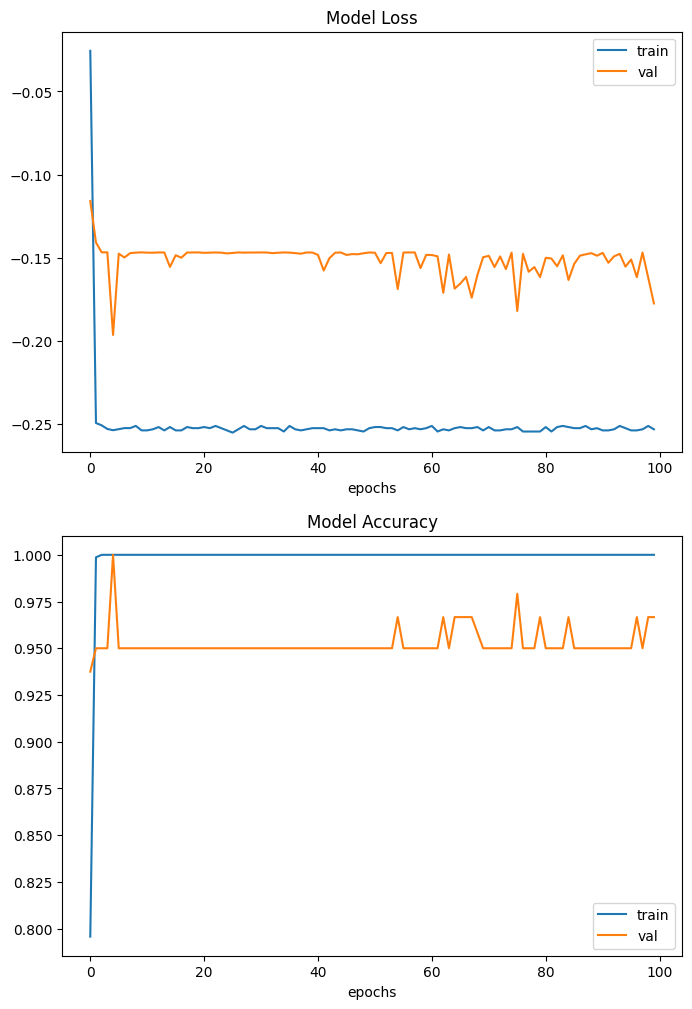

In [34]:

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax = ax.ravel()

ax[0].plot(his_trainloss)
ax[0].plot(his_valloss)
ax[0].set_title("Model {}".format("Loss"))
ax[0].set_xlabel("epochs")
ax[0].legend(["train", "val"])

ax[1].plot(his_trainacc)
ax[1].plot(his_valacc)
ax[1].set_title("Model {}".format("Accuracy"))
ax[1].set_xlabel("epochs")
# ax[1].set_ylabel(metric)
ax[1].legend(["train", "val"])